## INSTALL LIBRARIES

In [1]:
!pip install --quiet torch torchvision torchaudio
!pip install --quiet albumentations
!pip install --quiet rasterio
!pip install --quiet torchsummary
!pip install --quiet tqdm
!pip install tifffile
!pip install --quiet segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


##IMPORTS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
import numpy as np
import cv2
import os
import tifffile as tiff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import warnings
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader, random_split
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='albumentations')


##LOAD DATA

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/train.zip" -d "/content/train"
!unzip "/content/drive/MyDrive/evaluation.zip" -d "/content/evaluation"


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/mask/train_mask_218.tif  
  inflating: /content/train/mask/train_mask_219.tif  
  inflating: /content/train/mask/train_mask_22.tif  
  inflating: /content/train/mask/train_mask_220.tif  
  inflating: /content/train/mask/train_mask_221.tif  
  inflating: /content/train/mask/train_mask_222.tif  
  inflating: /content/train/mask/train_mask_223.tif  
  inflating: /content/train/mask/train_mask_224.tif  
  inflating: /content/train/mask/train_mask_225.tif  
  inflating: /content/train/mask/train_mask_226.tif  
  inflating: /content/train/mask/train_mask_227.tif  
  inflating: /content/train/mask/train_mask_228.tif  
  inflating: /content/train/mask/train_mask_229.tif  
  inflating: /content/train/mask/train_mask_23.tif  
  inflating: /content/train/mask/train_mask_230.tif  
  inflating: /content/train/mask/train_mask_231.tif  
  inflating: /content/train/mask/train_mask_232.tif  
  inflating: /content/train/mask/

In [5]:
!unzip "/content/drive/MyDrive/sample.zip" -d "/content/sample"

Archive:  /content/drive/MyDrive/sample.zip
  inflating: /content/sample/evaluation_mask_0.tif  
  inflating: /content/sample/evaluation_mask_1.tif  
  inflating: /content/sample/evaluation_mask_10.tif  
  inflating: /content/sample/evaluation_mask_100.tif  
  inflating: /content/sample/evaluation_mask_1000.tif  
  inflating: /content/sample/evaluation_mask_1001.tif  
  inflating: /content/sample/evaluation_mask_1002.tif  
  inflating: /content/sample/evaluation_mask_1003.tif  
  inflating: /content/sample/evaluation_mask_1004.tif  
  inflating: /content/sample/evaluation_mask_1005.tif  
  inflating: /content/sample/evaluation_mask_1006.tif  
  inflating: /content/sample/evaluation_mask_1007.tif  
  inflating: /content/sample/evaluation_mask_1008.tif  
  inflating: /content/sample/evaluation_mask_1009.tif  
  inflating: /content/sample/evaluation_mask_101.tif  
  inflating: /content/sample/evaluation_mask_1010.tif  
  inflating: /content/sample/evaluation_mask_1011.tif  
  inflating: /

In [6]:
train_images_path = "/content/train/s2_image"
train_masks_path = "/content/train/mask"
eval_images_path = "/content/evaluation/"
eval_mask_path = "/content/sample/"



In [7]:
!ls {train_images_path}
!ls {train_masks_path}

train_s2_image_0.tif	 train_s2_image_1620.tif  train_s2_image_381.tif
train_s2_image_1000.tif  train_s2_image_1621.tif  train_s2_image_382.tif
train_s2_image_1001.tif  train_s2_image_1622.tif  train_s2_image_383.tif
train_s2_image_1002.tif  train_s2_image_1623.tif  train_s2_image_384.tif
train_s2_image_1003.tif  train_s2_image_1624.tif  train_s2_image_385.tif
train_s2_image_1004.tif  train_s2_image_1625.tif  train_s2_image_386.tif
train_s2_image_1005.tif  train_s2_image_1626.tif  train_s2_image_387.tif
train_s2_image_1006.tif  train_s2_image_1627.tif  train_s2_image_388.tif
train_s2_image_1007.tif  train_s2_image_1628.tif  train_s2_image_389.tif
train_s2_image_1008.tif  train_s2_image_1629.tif  train_s2_image_38.tif
train_s2_image_1009.tif  train_s2_image_162.tif   train_s2_image_390.tif
train_s2_image_100.tif	 train_s2_image_1630.tif  train_s2_image_391.tif
train_s2_image_1010.tif  train_s2_image_1631.tif  train_s2_image_392.tif
train_s2_image_1011.tif  train_s2_image_1632.tif  train_

In [8]:
!ls {eval_images_path}
!ls {eval_mask_path}

evaluation_s2_image_0.tif     evaluation_s2_image_1930.tif
evaluation_s2_image_1000.tif  evaluation_s2_image_1931.tif
evaluation_s2_image_1001.tif  evaluation_s2_image_1932.tif
evaluation_s2_image_1002.tif  evaluation_s2_image_1933.tif
evaluation_s2_image_1003.tif  evaluation_s2_image_1934.tif
evaluation_s2_image_1004.tif  evaluation_s2_image_1935.tif
evaluation_s2_image_1005.tif  evaluation_s2_image_1936.tif
evaluation_s2_image_1006.tif  evaluation_s2_image_1937.tif
evaluation_s2_image_1007.tif  evaluation_s2_image_1938.tif
evaluation_s2_image_1008.tif  evaluation_s2_image_1939.tif
evaluation_s2_image_1009.tif  evaluation_s2_image_193.tif
evaluation_s2_image_100.tif   evaluation_s2_image_1940.tif
evaluation_s2_image_1010.tif  evaluation_s2_image_1941.tif
evaluation_s2_image_1011.tif  evaluation_s2_image_1942.tif
evaluation_s2_image_1012.tif  evaluation_s2_image_1943.tif
evaluation_s2_image_1013.tif  evaluation_s2_image_1944.tif
evaluation_s2_image_1014.tif  evaluation_s2_image_1945.ti

In [9]:
print(f"Train images path exists: {os.path.exists(train_images_path)}")
print(f"Train masks path exists: {os.path.exists(train_masks_path)}")

Train images path exists: True
Train masks path exists: True


##DISPLAYING  PICTURES AND MASKS


In [10]:
def normalize_img(img):
    img_min = img.min(axis=(0, 1), keepdims=True)
    img_max = img.max(axis=(0, 1), keepdims=True)
    return (img - img_min) / (img_max - img_min + 1e-6)

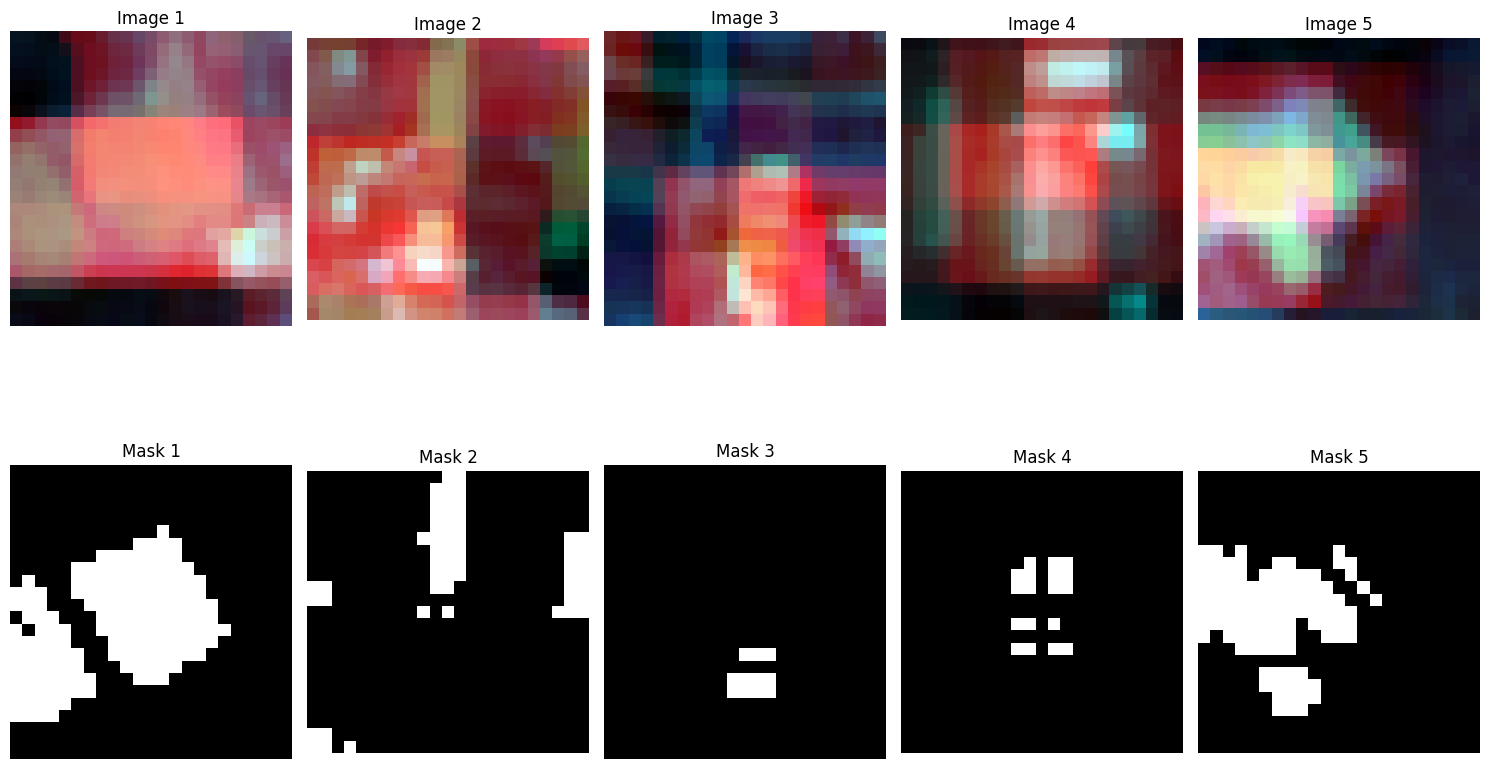

In [11]:
# Displaying some  images and masks
num_samples_to_display = 5
image_files = sorted([f for f in os.listdir(train_images_path) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(train_masks_path) if f.endswith('.tif')])

plt.figure(figsize=(15, 10))
for i in range(num_samples_to_display):
    img_path = os.path.join(train_images_path, image_files[i])
    image = rasterio.open(img_path).read([1, 2, 3]).transpose(1, 2, 0)
    image = normalize_img(image)

    # load mask
    mask_path = os.path.join(train_masks_path, mask_files[i])
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # display image
    plt.subplot(2, num_samples_to_display, i + 1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis("off")

    # display mask
    plt.subplot(2, num_samples_to_display, num_samples_to_display + i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

##IMAGE MASK SHAPE

In [12]:
image_files = sorted([f for f in os.listdir(train_images_path) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(train_masks_path) if f.endswith('.tif')])

sample_indices = random.sample(range(len(image_files)), 50)

for idx in sample_indices:
    image_file = image_files[idx]
    mask_file = image_file.replace("s2_image", "mask")

    image_path = os.path.join(train_images_path, image_file)
    mask_path = os.path.join(train_masks_path, mask_file)

    try:
        with rasterio.open(image_path) as img:
            image_data = img.read()

        with rasterio.open(mask_path) as msk:
            mask_data = msk.read(1)

        print(f"{image_file}: Image shape = {image_data.shape}, Mask shape = {mask_data.shape}")
    except Exception as e:
        print(f"Error reading {image_file} or {mask_file}: {e}")


train_s2_image_856.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_1747.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_1062.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_167.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_1805.tif: Image shape = (12, 25, 25), Mask shape = (25, 25)
train_s2_image_1829.tif: Image shape = (12, 23, 24), Mask shape = (23, 24)
train_s2_image_525.tif: Image shape = (12, 24, 23), Mask shape = (24, 23)
train_s2_image_665.tif: Image shape = (12, 23, 24), Mask shape = (23, 24)
train_s2_image_1664.tif: Image shape = (12, 24, 23), Mask shape = (24, 23)
train_s2_image_1850.tif: Image shape = (12, 24, 24), Mask shape = (24, 24)
train_s2_image_34.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_1796.tif: Image shape = (12, 24, 24), Mask shape = (24, 24)
train_s2_image_1941.tif: Image shape = (12, 23, 23), Mask shape = (23, 23)
train_s2_image_1685.tif: Image 

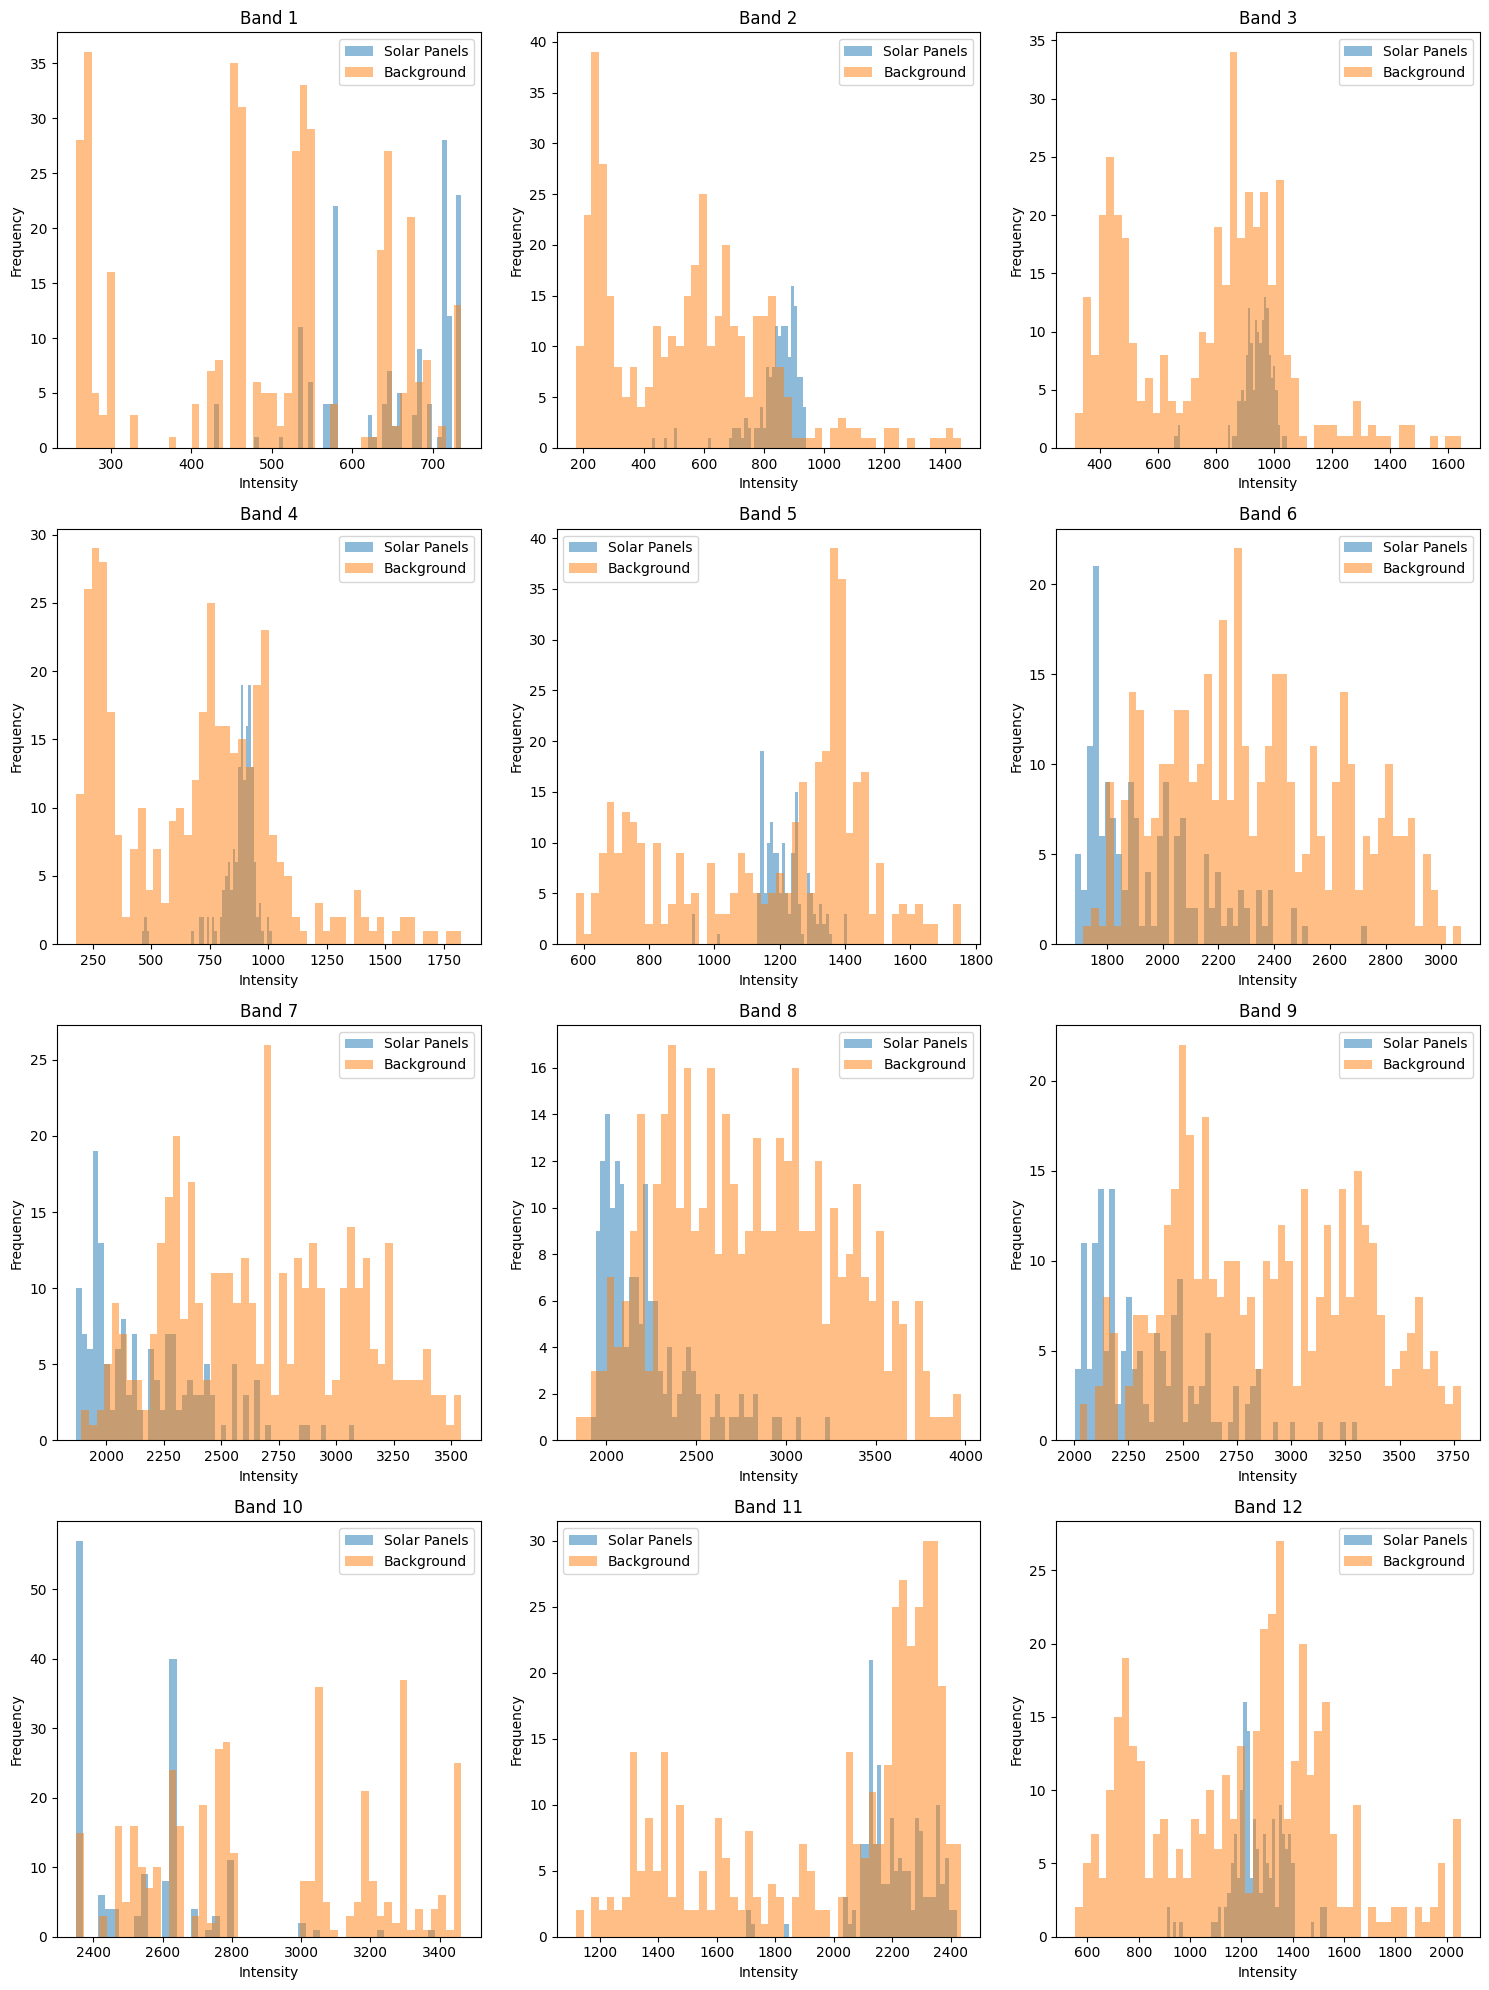

In [13]:
import matplotlib.pyplot as plt
import numpy as np

sample_image_path = os.path.join(train_images_path, image_files[0])
sample_mask_path = os.path.join(train_masks_path, mask_files[0])

with rasterio.open(sample_image_path) as img:
  sample_image_data = img.read().astype(np.float32)
with rasterio.open(sample_mask_path) as msk:
  sample_mask_data = msk.read(1)

mask_indices = np.where(sample_mask_data == 1)

if mask_indices[0].size > 0:
  band_values_at_panels = sample_image_data[:, mask_indices[0], mask_indices[1]]


  mean_intensities_at_panels = np.mean(band_values_at_panels, axis=1)

  background_indices = np.where(sample_mask_data == 0)
  if background_indices[0].size > 0:
    band_values_at_background = sample_image_data[:, background_indices[0], background_indices[1]]


    num_bands = sample_image_data.shape[0]
    plt.figure(figsize=(15, 5 * ((num_bands + 2) // 3)))
    for band_idx in range(num_bands):
      plt.subplot((num_bands + 2) // 3, 3, band_idx + 1)
      plt.hist(band_values_at_panels[band_idx, :], bins=50, alpha=0.5, label='Solar Panels')
      plt.hist(band_values_at_background[band_idx, :], bins=50, alpha=0.5, label='Background')
      plt.title(f'Band {band_idx + 1}')
      plt.xlabel('Intensity')
      plt.ylabel('Frequency')
      plt.legend()
    plt.tight_layout()
    plt.show()

  else:
    print("No background pixels found in the sample mask.")

else:
  print("No solar panel pixels found in the sample mask. Cannot perform band analysis.")

## DATA SPLIT AND FILTERING

In [14]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files,
    mask_files,
    test_size=0.2,
    random_state=42
)

print("="*50)
print(f"✅ Total dataset size: {len(image_files)}")
print(f"✅ Train set size:     {len(train_imgs)}")
print(f"✅ Validation set size:{len(val_imgs)}")
print("="*50)


✅ Total dataset size: 2066
✅ Train set size:     1652
✅ Validation set size:414


## CREATE DATASET

In [15]:
class SentinelSolarPanelDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # Bands that we will use [B2(Blue), B3(Green), B4(Red), B8(NIR), B11(SWIR1), B12(SWIR2)]
        self.band_indices = [1, 2, 3, 7, 10, 11]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        with rasterio.open(image_path) as img:
            image = img.read(self.band_indices).astype(np.float32)

        image = np.transpose(image, (1, 2, 0))  # (Height, Width, Channels(bands))
        with rasterio.open(mask_path) as msk:
            mask = msk.read(1).astype(np.uint8)  # (Height, Weight)

        if self.transform:
            if image.shape[:2] != mask.shape[:2]:
              print(f"[Shape mismatch] Image: {image.shape}, Mask: {mask.shape}, File: {self.image_files[idx]}")
            augmented = self.transform(image=image, mask=mask)

            image = augmented['image']
            mask = augmented["mask"].unsqueeze(0).long()  # shape [1, 128, 128]


        return image, mask


##UPSCALING IMAGES AND DATA AUGMENTATION

In [16]:
transform = A.Compose([
    A.Resize(128, 128),  # Upscale from 22-26 px
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    ToTensorV2()
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(128, 128),
    A.ToTensorV2()
],)

In [17]:
train_dataset = SentinelSolarPanelDataset(
    image_files=train_imgs,
    mask_files=train_masks,
    images_dir=train_images_path,
    masks_dir=train_masks_path,
    transform=transform
)

val_dataset = SentinelSolarPanelDataset(
    image_files=val_imgs,
    mask_files=val_masks,
    images_dir=train_images_path,
    masks_dir=train_masks_path,
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

In [18]:
sample_batch = next(iter(train_loader))
images, masks = sample_batch

print(f"Image batch shape: {images.shape}")  # Should be [16, 6, 128, 128]
print(f"Mask batch shape: {masks.shape}")    # Should be [16, 1, 128, 128]
print(f"Image dtype: {images.dtype}")
print(f"Mask dtype: {masks.dtype}")

Image batch shape: torch.Size([16, 6, 128, 128])
Mask batch shape: torch.Size([16, 1, 128, 128])
Image dtype: torch.float32
Mask dtype: torch.int64


##LOSS FUNCTIONS

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)

        bce = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        loss = self.alpha * ((1 - pt) ** self.gamma) * bce
        return loss.mean() if self.reduction == 'mean' else loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = inputs.sum() + targets.sum()
        dice = (2 * intersection + self.smooth) / (total + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, focal_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.focal = FocalLoss()
        self.dice = DiceLoss()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        f = self.focal(inputs, targets)
        d = self.dice(inputs, targets)
        return self.focal_weight * f + self.dice_weight * d, f, d

##METRICS

In [20]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float().view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return ((2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)).item()

def iou_score(pred, target, smooth=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float().view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return ((intersection + smooth) / (union + smooth)).item()

def f1_score(pred, target, smooth=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float().view(-1)
    target = target.view(-1)
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    return (2 * precision * recall / (precision + recall + smooth)).item()

##CREATE MODEL

In [21]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [22]:
def f1_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    pred = pred.view(-1)
    target = target.view(-1)
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * precision * recall / (precision + recall + smooth)
    return f1.item()


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_focal = 0
    total_dice = 0
    total_dice_score = 0
    total_iou = 0
    total_f1 = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch_idx, (images, masks) in enumerate(progress_bar):
        images = images.to(device)
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)

        loss, focal_loss, dice_loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Metrics
        dice_score = dice_coefficient(outputs, masks)
        iou = iou_score(outputs, masks)
        f1 = f1_score(outputs, masks)

        total_loss += loss.item()
        total_focal += focal_loss.item()
        total_dice += dice_loss.item()
        total_dice_score += dice_score
        total_iou += iou
        total_f1 += f1

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Dice': f'{dice_score:.4f}',
            'IoU': f'{iou:.4f}',
            'F1': f'{f1:.4f}'
        })

    avg_loss = total_loss / len(train_loader)
    avg_focal = total_focal / len(train_loader)
    avg_dice_loss = total_dice / len(train_loader)
    avg_dice_score = total_dice_score / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)

    return avg_loss, avg_focal, avg_dice_loss, avg_dice_score, avg_iou, avg_f1



def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice_score = 0
    total_iou = 0
    total_f1 = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")

        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)
            loss, _, _ = criterion(outputs, masks)

            dice_score = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            f1 = f1_score(outputs, masks)

            total_loss += loss.item()
            total_dice_score += dice_score
            total_iou += iou
            total_f1 += f1

            progress_bar.set_postfix({
                'Val Loss': f'{loss.item():.4f}',
                'Val Dice': f'{dice_score:.4f}',
                'Val IoU': f'{iou:.4f}',
                'Val F1': f'{f1:.4f}'
            })

    avg_loss = total_loss / len(val_loader)
    avg_dice_score = total_dice_score / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    avg_f1 = total_f1 / len(val_loader)

    return avg_loss, avg_dice_score, avg_iou, avg_f1

In [23]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Dice Score
    axes[1].plot(history['train_dice'], label='Train Dice', color='blue')
    axes[1].plot(history['val_dice'], label='Val Dice', color='red')
    axes[1].set_title('Dice Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].legend()
    axes[1].grid(True)

    # IoU Score
    axes[2].plot(history['train_iou'], label='Train IoU', color='blue')
    axes[2].plot(history['val_iou'], label='Val IoU', color='red')
    axes[2].set_title('IoU Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
def visualize_predictions(model, val_loader, device, num_samples=5):
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5

            # Convert to numpy for visualization
            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            predictions_np = predictions.cpu().numpy()

            # Plot first image in batch
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Show RGB composite (first 3 channels)
            rgb = np.transpose(images_np[0, :3], (1, 2, 0))
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize for display
            axes[0].imshow(rgb)
            axes[0].set_title('RGB Image')
            axes[0].axis('off')

            # Show ground truth
            axes[1].imshow(masks_np[0, 0], cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            # Show prediction
            axes[2].imshow(predictions_np[0, 0], cmap='gray')
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

In [25]:
def train_model(model, train_loader, val_loader, num_epochs=150, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = CombinedLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice': [], 'val_dice': [],
        'train_iou': [], 'val_iou': [],
        'train_f1': [], 'val_f1': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, _, _, train_dice, train_iou, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device)
        val_loss, val_dice, val_iou, val_f1 = validate_epoch(
            model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pth')
            print("✅ Best model saved!")

    return model, history


##TRAIN MODEL

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Starting training...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=150,
    learning_rate=1e-4,
    device=device
)
print("Training completed!")


Starting training...

Epoch 1/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.73it/s, Val Loss=0.9186, Val Dice=0.5265, Val IoU=0.3573, Val F1=0.5265]


✅ Best model saved!

Epoch 2/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.10it/s, Val Loss=0.8521, Val Dice=0.5195, Val IoU=0.3509, Val F1=0.5195]


✅ Best model saved!

Epoch 3/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.03it/s, Val Loss=0.8897, Val Dice=0.2956, Val IoU=0.1734, Val F1=0.2956]



Epoch 4/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.67it/s, Val Loss=0.9625, Val Dice=0.0912, Val IoU=0.0478, Val F1=0.0912]



Epoch 5/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.27it/s, Val Loss=0.6781, Val Dice=0.5559, Val IoU=0.3850, Val F1=0.5559]



Epoch 6/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.08it/s, Val Loss=0.8218, Val Dice=0.2876, Val IoU=0.1680, Val F1=0.2876]


✅ Best model saved!

Epoch 7/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.79it/s, Val Loss=0.7750, Val Dice=0.3546, Val IoU=0.2155, Val F1=0.3546]


✅ Best model saved!

Epoch 8/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.89it/s, Val Loss=0.5860, Val Dice=0.5737, Val IoU=0.4022, Val F1=0.5737]


✅ Best model saved!

Epoch 9/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.28it/s, Val Loss=0.5801, Val Dice=0.5689, Val IoU=0.3975, Val F1=0.5689]



Epoch 10/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  7.72it/s, Val Loss=0.8365, Val Dice=0.2816, Val IoU=0.1639, Val F1=0.2816]



Epoch 11/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.69it/s, Val Loss=0.6999, Val Dice=0.3983, Val IoU=0.2487, Val F1=0.3983]


✅ Best model saved!

Epoch 12/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.03it/s, Val Loss=0.7817, Val Dice=0.3102, Val IoU=0.1836, Val F1=0.3102]



Epoch 13/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.94it/s, Val Loss=0.6247, Val Dice=0.5056, Val IoU=0.3383, Val F1=0.5056]


✅ Best model saved!

Epoch 14/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.23it/s, Val Loss=0.6785, Val Dice=0.4323, Val IoU=0.2758, Val F1=0.4323]



Epoch 15/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.16it/s, Val Loss=0.7564, Val Dice=0.3429, Val IoU=0.2070, Val F1=0.3429]



Epoch 16/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.75it/s, Val Loss=0.7541, Val Dice=0.3435, Val IoU=0.2074, Val F1=0.3435]



Epoch 17/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.95it/s, Val Loss=0.6947, Val Dice=0.3873, Val IoU=0.2402, Val F1=0.3873]



Epoch 18/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.70it/s, Val Loss=0.7261, Val Dice=0.3567, Val IoU=0.2171, Val F1=0.3567]



Epoch 19/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.20it/s, Val Loss=0.6191, Val Dice=0.4742, Val IoU=0.3108, Val F1=0.4742]


✅ Best model saved!

Epoch 20/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.32it/s, Val Loss=0.6546, Val Dice=0.4293, Val IoU=0.2733, Val F1=0.4293]



Epoch 21/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.25it/s, Val Loss=0.7386, Val Dice=0.3371, Val IoU=0.2027, Val F1=0.3371]



Epoch 22/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.67it/s, Val Loss=0.7957, Val Dice=0.3163, Val IoU=0.1878, Val F1=0.3163]



Epoch 23/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.02it/s, Val Loss=0.6773, Val Dice=0.4134, Val IoU=0.2605, Val F1=0.4134]



Epoch 24/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.82it/s, Val Loss=0.6362, Val Dice=0.4676, Val IoU=0.3051, Val F1=0.4676]



Epoch 25/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.79it/s, Val Loss=0.7611, Val Dice=0.3021, Val IoU=0.1780, Val F1=0.3021]



Epoch 26/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.04it/s, Val Loss=0.7648, Val Dice=0.3353, Val IoU=0.2014, Val F1=0.3353]



Epoch 27/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.85it/s, Val Loss=0.6371, Val Dice=0.4394, Val IoU=0.2816, Val F1=0.4394]



Epoch 28/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.47it/s, Val Loss=0.6419, Val Dice=0.4741, Val IoU=0.3107, Val F1=0.4741]



Epoch 29/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.34it/s, Val Loss=0.6763, Val Dice=0.4386, Val IoU=0.2809, Val F1=0.4386]



Epoch 30/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.74it/s, Val Loss=0.7811, Val Dice=0.3169, Val IoU=0.1883, Val F1=0.3169]



Epoch 31/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.41it/s, Val Loss=0.6665, Val Dice=0.4619, Val IoU=0.3003, Val F1=0.4619]


✅ Best model saved!

Epoch 32/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.06it/s, Val Loss=0.7434, Val Dice=0.3600, Val IoU=0.2195, Val F1=0.3600]



Epoch 33/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.43it/s, Val Loss=0.5623, Val Dice=0.5662, Val IoU=0.3949, Val F1=0.5662]



Epoch 34/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.11it/s, Val Loss=0.7154, Val Dice=0.3872, Val IoU=0.2401, Val F1=0.3872]


✅ Best model saved!

Epoch 35/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, Val Loss=0.6394, Val Dice=0.4770, Val IoU=0.3132, Val F1=0.4770]



Epoch 36/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.99it/s, Val Loss=0.6197, Val Dice=0.4958, Val IoU=0.3296, Val F1=0.4958]


✅ Best model saved!

Epoch 37/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.12it/s, Val Loss=0.7165, Val Dice=0.4049, Val IoU=0.2538, Val F1=0.4049]



Epoch 38/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.85it/s, Val Loss=0.7565, Val Dice=0.3618, Val IoU=0.2209, Val F1=0.3618]



Epoch 39/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.44it/s, Val Loss=0.7481, Val Dice=0.3234, Val IoU=0.1929, Val F1=0.3234]



Epoch 40/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.30it/s, Val Loss=0.7323, Val Dice=0.3483, Val IoU=0.2109, Val F1=0.3483]



Epoch 41/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.60it/s, Val Loss=0.6880, Val Dice=0.3954, Val IoU=0.2464, Val F1=0.3954]



Epoch 42/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.86it/s, Val Loss=0.6017, Val Dice=0.5029, Val IoU=0.3359, Val F1=0.5029]



Epoch 43/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.76it/s, Val Loss=0.6679, Val Dice=0.4193, Val IoU=0.2653, Val F1=0.4193]


✅ Best model saved!

Epoch 44/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.87it/s, Val Loss=0.6828, Val Dice=0.4013, Val IoU=0.2510, Val F1=0.4013]


✅ Best model saved!

Epoch 45/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.29it/s, Val Loss=0.5897, Val Dice=0.5161, Val IoU=0.3478, Val F1=0.5161]



Epoch 46/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.96it/s, Val Loss=0.6265, Val Dice=0.4702, Val IoU=0.3074, Val F1=0.4702]



Epoch 47/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.25it/s, Val Loss=0.7487, Val Dice=0.3802, Val IoU=0.2347, Val F1=0.3802]



Epoch 48/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.18it/s, Val Loss=0.7247, Val Dice=0.4137, Val IoU=0.2608, Val F1=0.4137]



Epoch 49/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  7.53it/s, Val Loss=0.6227, Val Dice=0.4847, Val IoU=0.3199, Val F1=0.4847]



Epoch 50/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.67it/s, Val Loss=0.6149, Val Dice=0.4789, Val IoU=0.3149, Val F1=0.4789]



Epoch 51/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.43it/s, Val Loss=0.7288, Val Dice=0.3770, Val IoU=0.2323, Val F1=0.3770]



Epoch 52/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, Val Loss=0.5851, Val Dice=0.5325, Val IoU=0.3628, Val F1=0.5325]



Epoch 53/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.49it/s, Val Loss=0.6052, Val Dice=0.4850, Val IoU=0.3201, Val F1=0.4850]



Epoch 54/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.46it/s, Val Loss=0.5150, Val Dice=0.5967, Val IoU=0.4252, Val F1=0.5966]



Epoch 55/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.13it/s, Val Loss=0.6407, Val Dice=0.4544, Val IoU=0.2940, Val F1=0.4544]



Epoch 56/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.21it/s, Val Loss=0.5647, Val Dice=0.5578, Val IoU=0.3868, Val F1=0.5578]



Epoch 57/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.35it/s, Val Loss=0.6297, Val Dice=0.5025, Val IoU=0.3356, Val F1=0.5025]



Epoch 58/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  8.56it/s, Val Loss=0.5299, Val Dice=0.5752, Val IoU=0.4037, Val F1=0.5752]



Epoch 59/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, Val Loss=0.5491, Val Dice=0.5743, Val IoU=0.4029, Val F1=0.5743]



Epoch 60/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.80it/s, Val Loss=0.7523, Val Dice=0.3709, Val IoU=0.2277, Val F1=0.3709]



Epoch 61/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.35it/s, Val Loss=0.6637, Val Dice=0.4364, Val IoU=0.2791, Val F1=0.4364]



Epoch 62/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.69it/s, Val Loss=0.7465, Val Dice=0.3621, Val IoU=0.2211, Val F1=0.3621]



Epoch 63/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.83it/s, Val Loss=0.5812, Val Dice=0.5429, Val IoU=0.3726, Val F1=0.5429]



Epoch 64/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.32it/s, Val Loss=0.6080, Val Dice=0.5026, Val IoU=0.3357, Val F1=0.5026]



Epoch 65/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.34it/s, Val Loss=0.7430, Val Dice=0.3676, Val IoU=0.2252, Val F1=0.3676]



Epoch 66/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.87it/s, Val Loss=0.6453, Val Dice=0.4586, Val IoU=0.2975, Val F1=0.4586]



Epoch 67/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, Val Loss=0.5270, Val Dice=0.5809, Val IoU=0.4093, Val F1=0.5809]


✅ Best model saved!

Epoch 68/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.67it/s, Val Loss=0.7220, Val Dice=0.3627, Val IoU=0.2215, Val F1=0.3627]



Epoch 69/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.38it/s, Val Loss=0.5243, Val Dice=0.5907, Val IoU=0.4192, Val F1=0.5907]



Epoch 70/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.68it/s, Val Loss=0.7093, Val Dice=0.4341, Val IoU=0.2772, Val F1=0.4341]



Epoch 71/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  8.16it/s, Val Loss=0.7262, Val Dice=0.4227, Val IoU=0.2680, Val F1=0.4227]



Epoch 72/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.45it/s, Val Loss=0.6952, Val Dice=0.3954, Val IoU=0.2464, Val F1=0.3954]



Epoch 73/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.52it/s, Val Loss=0.6953, Val Dice=0.3909, Val IoU=0.2430, Val F1=0.3909]



Epoch 74/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.73it/s, Val Loss=0.5847, Val Dice=0.4976, Val IoU=0.3312, Val F1=0.4976]



Epoch 75/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.58it/s, Val Loss=0.6203, Val Dice=0.4813, Val IoU=0.3169, Val F1=0.4813]



Epoch 76/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.43it/s, Val Loss=0.6540, Val Dice=0.4274, Val IoU=0.2718, Val F1=0.4274]



Epoch 77/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.44it/s, Val Loss=0.6449, Val Dice=0.4308, Val IoU=0.2746, Val F1=0.4308]



Epoch 78/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.26it/s, Val Loss=0.5809, Val Dice=0.5121, Val IoU=0.3442, Val F1=0.5121]



Epoch 79/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.62it/s, Val Loss=0.5661, Val Dice=0.5224, Val IoU=0.3536, Val F1=0.5224]



Epoch 80/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.55it/s, Val Loss=0.7069, Val Dice=0.4165, Val IoU=0.2630, Val F1=0.4165]



Epoch 81/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, Val Loss=0.6001, Val Dice=0.4951, Val IoU=0.3290, Val F1=0.4951]


✅ Best model saved!

Epoch 82/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.72it/s, Val Loss=0.5579, Val Dice=0.5487, Val IoU=0.3781, Val F1=0.5487]


✅ Best model saved!

Epoch 83/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.96it/s, Val Loss=0.6067, Val Dice=0.5045, Val IoU=0.3373, Val F1=0.5045]



Epoch 84/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.71it/s, Val Loss=0.6155, Val Dice=0.4905, Val IoU=0.3250, Val F1=0.4905]



Epoch 85/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.39it/s, Val Loss=0.5885, Val Dice=0.5061, Val IoU=0.3388, Val F1=0.5061]



Epoch 86/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.15it/s, Val Loss=0.5463, Val Dice=0.5444, Val IoU=0.3740, Val F1=0.5444]



Epoch 87/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.27it/s, Val Loss=0.6459, Val Dice=0.4794, Val IoU=0.3152, Val F1=0.4794]



Epoch 88/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  8.55it/s, Val Loss=0.6624, Val Dice=0.4554, Val IoU=0.2948, Val F1=0.4554]



Epoch 89/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.50it/s, Val Loss=0.6391, Val Dice=0.4669, Val IoU=0.3046, Val F1=0.4669]



Epoch 90/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.33it/s, Val Loss=0.6875, Val Dice=0.4462, Val IoU=0.2871, Val F1=0.4462]



Epoch 91/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.46it/s, Val Loss=0.6487, Val Dice=0.4863, Val IoU=0.3213, Val F1=0.4863]



Epoch 92/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.56it/s, Val Loss=0.6854, Val Dice=0.4408, Val IoU=0.2827, Val F1=0.4408]



Epoch 93/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.06it/s, Val Loss=0.6453, Val Dice=0.4794, Val IoU=0.3152, Val F1=0.4794]



Epoch 94/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.52it/s, Val Loss=0.6821, Val Dice=0.4490, Val IoU=0.2895, Val F1=0.4490]



Epoch 95/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.34it/s, Val Loss=0.7235, Val Dice=0.4005, Val IoU=0.2504, Val F1=0.4005]



Epoch 96/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.15it/s, Val Loss=0.6840, Val Dice=0.4424, Val IoU=0.2840, Val F1=0.4424]



Epoch 97/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.80it/s, Val Loss=0.6798, Val Dice=0.4197, Val IoU=0.2656, Val F1=0.4197]



Epoch 98/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.36it/s, Val Loss=0.6310, Val Dice=0.4898, Val IoU=0.3243, Val F1=0.4898]



Epoch 99/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.37it/s, Val Loss=0.7229, Val Dice=0.3767, Val IoU=0.2321, Val F1=0.3767]



Epoch 100/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, Val Loss=0.7068, Val Dice=0.4079, Val IoU=0.2562, Val F1=0.4079]



Epoch 101/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.92it/s, Val Loss=0.7698, Val Dice=0.3744, Val IoU=0.2304, Val F1=0.3744]



Epoch 102/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, Val Loss=0.7089, Val Dice=0.4297, Val IoU=0.2737, Val F1=0.4297]



Epoch 103/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, Val Loss=0.7056, Val Dice=0.4412, Val IoU=0.2830, Val F1=0.4412]



Epoch 104/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.25it/s, Val Loss=0.6920, Val Dice=0.4263, Val IoU=0.2709, Val F1=0.4263]



Epoch 105/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.35it/s, Val Loss=0.5828, Val Dice=0.5263, Val IoU=0.3571, Val F1=0.5263]



Epoch 106/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.48it/s, Val Loss=0.5039, Val Dice=0.5932, Val IoU=0.4216, Val F1=0.5932]



Epoch 107/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.36it/s, Val Loss=0.6209, Val Dice=0.5036, Val IoU=0.3365, Val F1=0.5036]



Epoch 108/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.44it/s, Val Loss=0.6302, Val Dice=0.4692, Val IoU=0.3065, Val F1=0.4692]



Epoch 109/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  8.59it/s, Val Loss=0.5987, Val Dice=0.5170, Val IoU=0.3486, Val F1=0.5170]



Epoch 110/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  8.71it/s, Val Loss=0.7008, Val Dice=0.4271, Val IoU=0.2716, Val F1=0.4271]



Epoch 111/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, Val Loss=0.6836, Val Dice=0.4553, Val IoU=0.2947, Val F1=0.4553]



Epoch 112/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.20it/s, Val Loss=0.6766, Val Dice=0.4558, Val IoU=0.2951, Val F1=0.4558]



Epoch 113/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.34it/s, Val Loss=0.6130, Val Dice=0.4798, Val IoU=0.3156, Val F1=0.4798]



Epoch 114/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.57it/s, Val Loss=0.6409, Val Dice=0.4548, Val IoU=0.2943, Val F1=0.4548]



Epoch 115/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.26it/s, Val Loss=0.5505, Val Dice=0.5574, Val IoU=0.3864, Val F1=0.5574]



Epoch 116/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.30it/s, Val Loss=0.7475, Val Dice=0.3821, Val IoU=0.2361, Val F1=0.3821]



Epoch 117/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.20it/s, Val Loss=0.6542, Val Dice=0.4433, Val IoU=0.2848, Val F1=0.4433]



Epoch 118/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.71it/s, Val Loss=0.6694, Val Dice=0.4474, Val IoU=0.2881, Val F1=0.4474]



Epoch 119/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.95it/s, Val Loss=0.6116, Val Dice=0.4878, Val IoU=0.3226, Val F1=0.4878]



Epoch 120/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.90it/s, Val Loss=0.6419, Val Dice=0.4784, Val IoU=0.3144, Val F1=0.4784]



Epoch 121/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.51it/s, Val Loss=0.5671, Val Dice=0.5289, Val IoU=0.3595, Val F1=0.5289]



Epoch 122/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, Val Loss=0.5296, Val Dice=0.5755, Val IoU=0.4040, Val F1=0.5755]



Epoch 123/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s, Val Loss=0.5770, Val Dice=0.5286, Val IoU=0.3592, Val F1=0.5285]



Epoch 124/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.18it/s, Val Loss=0.6104, Val Dice=0.4820, Val IoU=0.3175, Val F1=0.4820]



Epoch 125/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.19it/s, Val Loss=0.6649, Val Dice=0.4381, Val IoU=0.2805, Val F1=0.4381]



Epoch 126/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.19it/s, Val Loss=0.6222, Val Dice=0.4905, Val IoU=0.3250, Val F1=0.4905]



Epoch 127/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.67it/s, Val Loss=0.5732, Val Dice=0.5252, Val IoU=0.3562, Val F1=0.5252]



Epoch 128/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.09it/s, Val Loss=0.6660, Val Dice=0.4501, Val IoU=0.2904, Val F1=0.4501]



Epoch 129/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.25it/s, Val Loss=0.5426, Val Dice=0.5552, Val IoU=0.3843, Val F1=0.5552]



Epoch 130/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.44it/s, Val Loss=0.5582, Val Dice=0.5481, Val IoU=0.3775, Val F1=0.5481]



Epoch 131/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.57it/s, Val Loss=0.6026, Val Dice=0.5054, Val IoU=0.3381, Val F1=0.5054]



Epoch 132/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.01it/s, Val Loss=0.4947, Val Dice=0.5926, Val IoU=0.4211, Val F1=0.5926]



Epoch 133/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.18it/s, Val Loss=0.5677, Val Dice=0.5328, Val IoU=0.3631, Val F1=0.5328]



Epoch 134/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, Val Loss=0.5877, Val Dice=0.5125, Val IoU=0.3446, Val F1=0.5125]



Epoch 135/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.42it/s, Val Loss=0.5313, Val Dice=0.5725, Val IoU=0.4011, Val F1=0.5725]


✅ Best model saved!

Epoch 136/150


Validation: 100%|██████████| 26/26 [00:03<00:00,  7.82it/s, Val Loss=0.5900, Val Dice=0.5131, Val IoU=0.3450, Val F1=0.5131]



Epoch 137/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.47it/s, Val Loss=0.6621, Val Dice=0.4424, Val IoU=0.2841, Val F1=0.4424]



Epoch 138/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.18it/s, Val Loss=0.6401, Val Dice=0.4755, Val IoU=0.3119, Val F1=0.4755]



Epoch 139/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.00it/s, Val Loss=0.6890, Val Dice=0.4295, Val IoU=0.2735, Val F1=0.4295]



Epoch 140/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.03it/s, Val Loss=0.6584, Val Dice=0.4629, Val IoU=0.3011, Val F1=0.4629]



Epoch 141/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s, Val Loss=0.6950, Val Dice=0.4255, Val IoU=0.2702, Val F1=0.4255]



Epoch 142/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.96it/s, Val Loss=0.6285, Val Dice=0.4881, Val IoU=0.3229, Val F1=0.4881]



Epoch 143/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 12.74it/s, Val Loss=0.5643, Val Dice=0.5324, Val IoU=0.3628, Val F1=0.5324]



Epoch 144/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.51it/s, Val Loss=0.6694, Val Dice=0.4390, Val IoU=0.2812, Val F1=0.4390]



Epoch 145/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.93it/s, Val Loss=0.6397, Val Dice=0.4559, Val IoU=0.2952, Val F1=0.4559]



Epoch 146/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.01it/s, Val Loss=0.6175, Val Dice=0.4656, Val IoU=0.3034, Val F1=0.4656]



Epoch 147/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.46it/s, Val Loss=0.5546, Val Dice=0.5466, Val IoU=0.3761, Val F1=0.5466]



Epoch 148/150


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.22it/s, Val Loss=0.6730, Val Dice=0.4348, Val IoU=0.2778, Val F1=0.4348]



Epoch 149/150


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.98it/s, Val Loss=0.6042, Val Dice=0.4926, Val IoU=0.3268, Val F1=0.4926]



Epoch 150/150


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.78it/s, Val Loss=0.5004, Val Dice=0.6124, Val IoU=0.4413, Val F1=0.6124]

Training completed!


##CHECK MODEL PREDICTIONS

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            for i in range(images.size(0)):
                if count >= num_samples:
                    return

                img = images[i].cpu().numpy()
                gt_mask = masks[i].cpu().numpy()
                pred_mask = preds[i].cpu().numpy()

                # Select RGB (first 3 bands) and normalize for display
                rgb = img[:3]  # shape [3, H, W]
                rgb = np.transpose(rgb, (1, 2, 0))  # [H, W, 3]
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(rgb)
                axs[0].set_title("RGB Image")
                axs[0].axis("off")

                axs[1].imshow(gt_mask[0], cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred_mask[0], cmap="gray")
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()

                count += 1


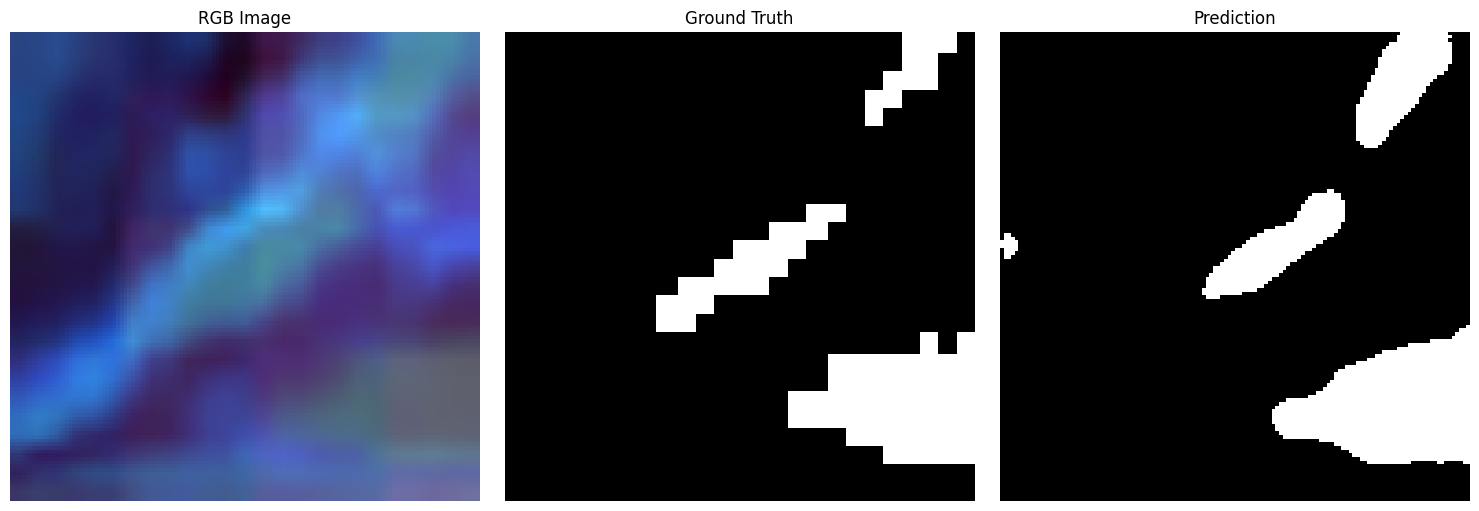

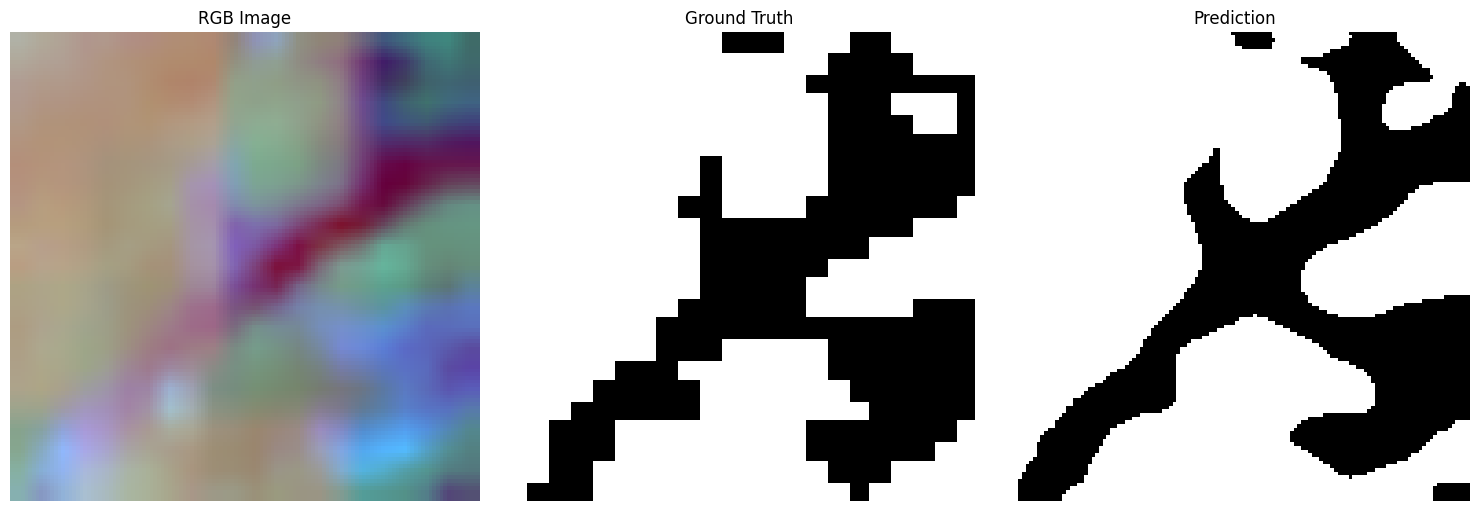

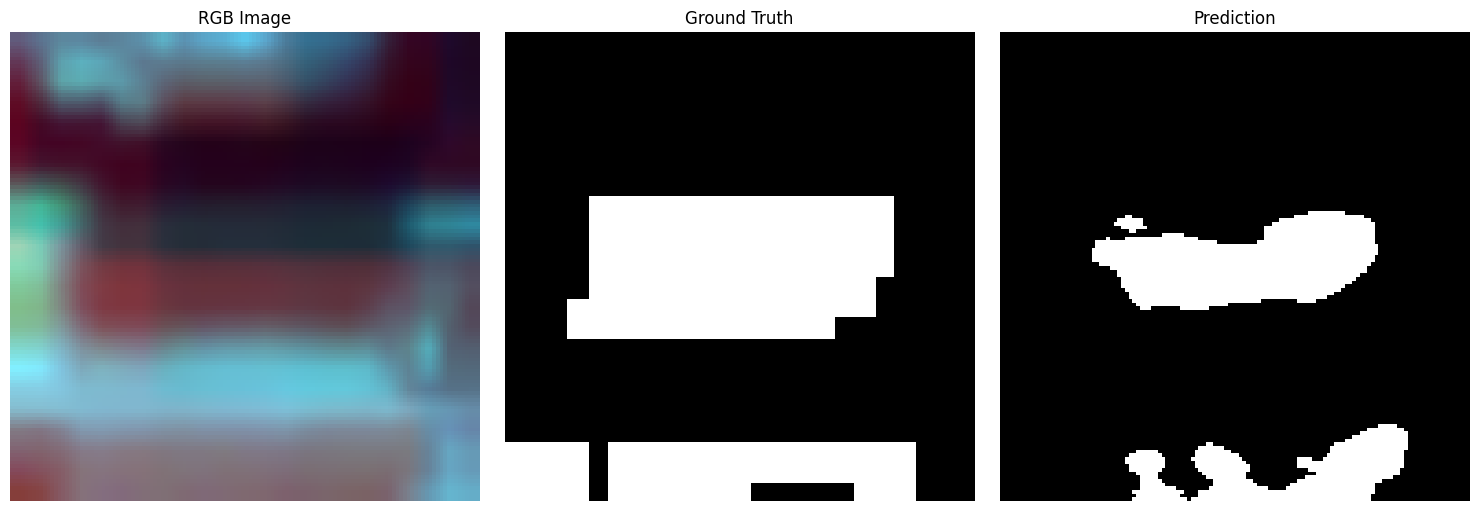

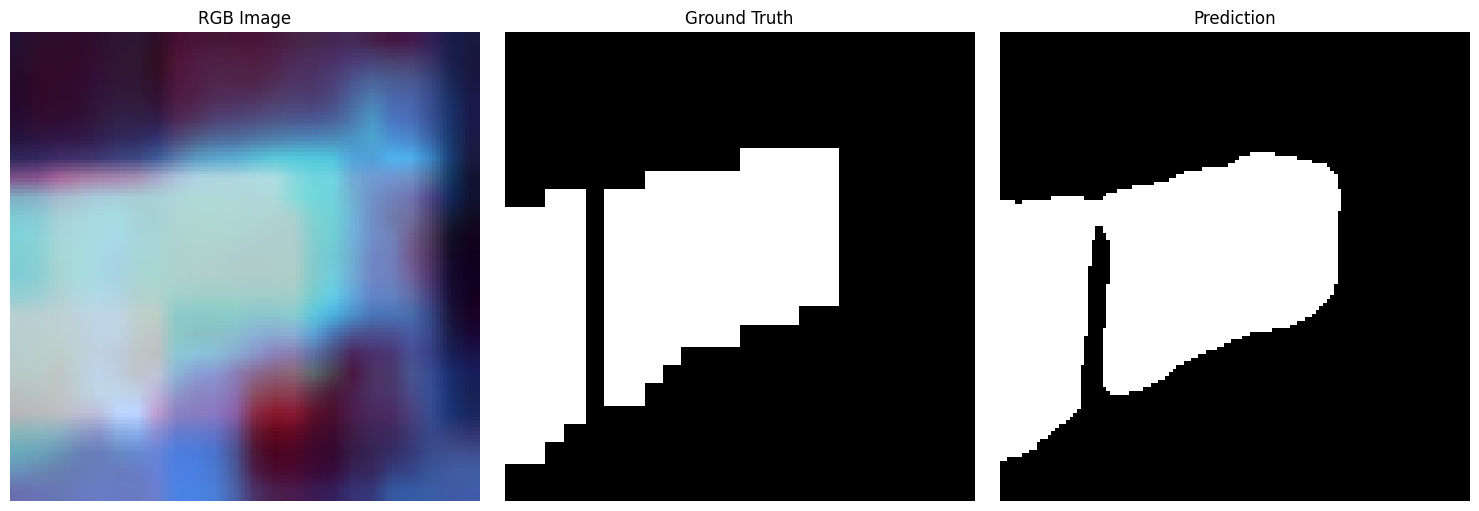

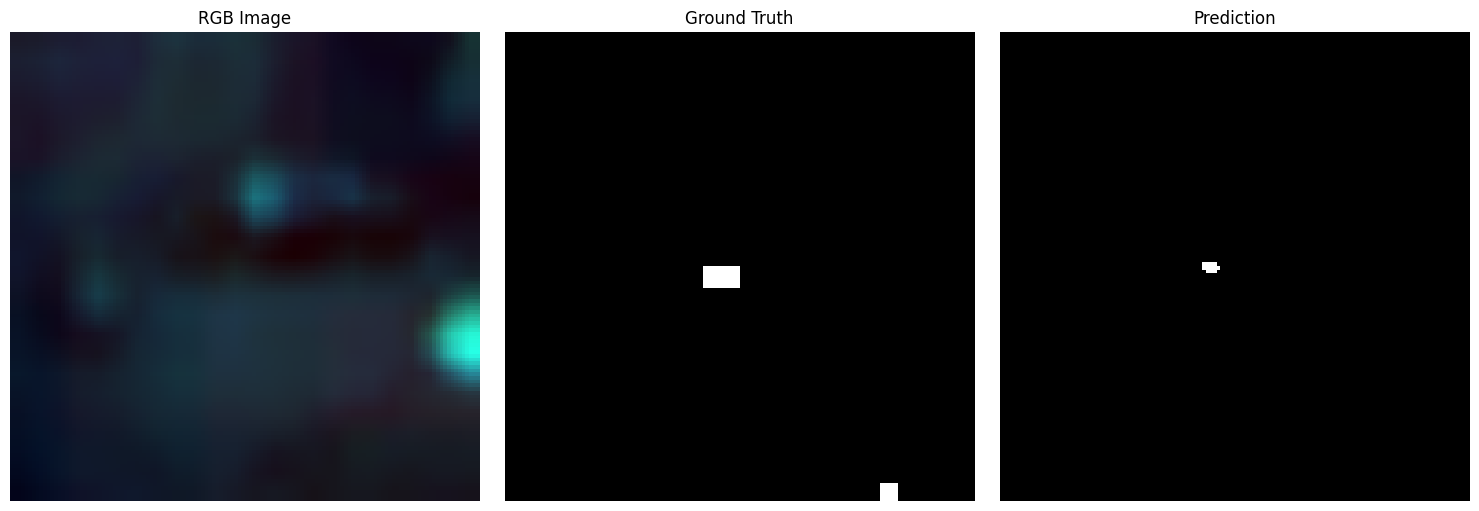

In [107]:
visualize_predictions(model, val_loader, device, num_samples=5)


## MODEL METRICS ON TRAINING DATASET

In [30]:
import segmentation_models_pytorch as smp
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score

def calculate_metrics(preds, targets):
    preds = preds.flatten()
    targets = targets.flatten()

    f1 = f1_score(targets, preds, zero_division=1)
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    iou = jaccard_score(targets, preds, zero_division=1)

    return f1, precision, recall, iou


In [32]:
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

f1, precision, recall, iou = calculate_metrics(all_preds, all_targets)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")


F1 Score: 0.7907
Precision: 0.7666
Recall: 0.8164
IoU: 0.6538


##MODEL METRICS ON EVALUATION DATASET

In [67]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading trained model...")
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()
print("✅ Model loaded successfully!")


class SentinelSolarPanelEvalDataset(Dataset):
    def __init__(self, image_files, images_dir, transform=None):
        self.image_files = image_files
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image filename
        image_file = self.image_files[idx]

        # Load image using rasterio
        image_path = os.path.join(self.images_dir, image_file)
        with rasterio.open(image_path) as img:
            image = img.read()  # Shape: (bands, height, width)

        # Select same bands as training: [1, 2, 3, 7, 8, 11] (0-indexed: [0,1,2,6,7,10])
        selected_bands = [0, 1, 2, 6, 7, 10]
        image = image[selected_bands]  # Shape: (6, height, width)

        # IMPORTANT: Convert to float32 to avoid type issues
        image = image.astype(np.float32)

        # Normalize to [0, 1] range if needed
        if image.max() > 1:
            image = image / 10000.0  # Typical normalization for Sentinel-2

        # Transpose to (height, width, channels) for albumentations
        image = np.transpose(image, (1, 2, 0))  # Shape: (height, width, 6)

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        # Ensure the tensor is float32
        image = image.float()

        return image, image_file


eval_transform = A.Compose([
    A.Resize(128, 128),
    A.ToTensorV2(transpose_mask=True)
], is_check_shapes=False)

# 5. SET UP DATASET AND DATALOADER
print("Setting up evaluation dataset...")
eval_images_path = "/content/evaluation/"
eval_imgs = [f for f in os.listdir(eval_images_path) if f.endswith('.tif')]
print(f"Found {len(eval_imgs)} evaluation images")

eval_dataset = SentinelSolarPanelEvalDataset(
    image_files=eval_imgs,
    images_dir=eval_images_path,
    transform=eval_transform
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0
)





# 7. COMPREHENSIVE METRICS FUNCTIONS
def calculate_segmentation_metrics(pred, target, threshold=0.5):
    """Calculate comprehensive segmentation metrics"""
    # Convert to binary
    pred_binary = (pred > threshold).float()
    target_binary = target.float()

    # Flatten tensors
    pred_flat = pred_binary.view(-1)
    target_flat = target_binary.view(-1)

    # True Positives, False Positives, True Negatives, False Negatives
    tp = (pred_flat * target_flat).sum()
    fp = (pred_flat * (1 - target_flat)).sum()
    tn = ((1 - pred_flat) * (1 - target_flat)).sum()
    fn = ((1 - pred_flat) * target_flat).sum()

    # Avoid division by zero
    epsilon = 1e-7

    # Accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn + epsilon)

    # Precision (Positive Predictive Value)
    precision = tp / (tp + fp + epsilon)

    # Recall (Sensitivity/True Positive Rate)
    recall = tp / (tp + fn + epsilon)

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    # IoU (Intersection over Union / Jaccard Index)
    intersection = tp
    union = tp + fp + fn
    iou = intersection / (union + epsilon)

    # Dice Coefficient (F1 Score for segmentation)
    dice = 2 * intersection / (2 * intersection + fp + fn + epsilon)

    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp + epsilon)

    # Balanced Accuracy
    balanced_accuracy = (recall + specificity) / 2

    return {
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1_score': f1.item(),
        'iou': iou.item(),
        'dice': dice.item(),
        'specificity': specificity.item(),
        'balanced_accuracy': balanced_accuracy.item(),
        'tp': tp.item(),
        'fp': fp.item(),
        'tn': tn.item(),
        'fn': fn.item()
    }

def calculate_loss_metrics(pred_logits, target, loss_fn=None):
    """Calculate various loss metrics"""
    import torch.nn.functional as F

    # Binary Cross Entropy Loss
    bce_loss = F.binary_cross_entropy_with_logits(pred_logits, target.float())

    # Sigmoid predictions for other losses
    pred_sigmoid = torch.sigmoid(pred_logits)

    # Dice Loss
    intersection = (pred_sigmoid * target).sum()
    dice_loss = 1 - (2 * intersection + 1e-7) / (pred_sigmoid.sum() + target.sum() + 1e-7)

    # Focal Loss (manual implementation)
    alpha = 0.25
    gamma = 2.0
    ce_loss = F.binary_cross_entropy_with_logits(pred_logits, target.float(), reduction='none')
    p_t = pred_sigmoid * target + (1 - pred_sigmoid) * (1 - target)
    focal_loss = alpha * (1 - p_t) ** gamma * ce_loss
    focal_loss = focal_loss.mean()

    # Combined Loss (BCE + Dice)
    combined_loss = bce_loss + dice_loss

    return {
        'bce_loss': bce_loss.item(),
        'dice_loss': dice_loss.item(),
        'focal_loss': focal_loss.item(),
        'combined_loss': combined_loss.item()
    }

def calculate_prediction_stats(probabilities, predictions):
    """Calculate prediction statistics for evaluation data"""
    stats = {
        'mean_probability': float(probabilities.mean()),
        'std_probability': float(probabilities.std()),
        'max_probability': float(probabilities.max()),
        'min_probability': float(probabilities.min()),
        'positive_pixels': int(predictions.sum()),
        'total_pixels': int(predictions.size),
        'positive_ratio': float(predictions.mean()),
        'confidence_score': float(probabilities.max()),
        'entropy': float(-((probabilities * torch.log(probabilities + 1e-7)) +
                          ((1 - probabilities) * torch.log(1 - probabilities + 1e-7))).mean())
    }
    return stats

# 7a. VALIDATION METRICS FUNCTION
def evaluate_on_validation_set(model, val_loader, device):
    """Evaluate model on validation set with ground truth"""
    model.eval()

    all_metrics = []
    all_losses = []

    print("\n=== EVALUATING ON VALIDATION SET ===")

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(val_loader, desc="Validation evaluation")):
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)

            # Calculate metrics for each sample in batch
            for i in range(images.shape[0]):
                pred = probabilities[i, 0]
                target = masks[i, 0] if masks.ndim == 4 else masks[i]
                pred_logits = outputs[i, 0]

                # Segmentation metrics
                seg_metrics = calculate_segmentation_metrics(pred, target)
                all_metrics.append(seg_metrics)

                # Loss metrics
                loss_metrics = calculate_loss_metrics(pred_logits.unsqueeze(0).unsqueeze(0),
                                                    target.unsqueeze(0).unsqueeze(0))
                all_losses.append(loss_metrics)

    # Aggregate metrics
    avg_metrics = {}
    for key in all_metrics[0].keys():
        avg_metrics[f'avg_{key}'] = np.mean([m[key] for m in all_metrics])
        avg_metrics[f'std_{key}'] = np.std([m[key] for m in all_metrics])

    avg_losses = {}
    for key in all_losses[0].keys():
        avg_losses[f'avg_{key}'] = np.mean([l[key] for l in all_losses])
        avg_losses[f'std_{key}'] = np.std([l[key] for l in all_losses])

    # Print validation results


    print(f"Average IoU: {avg_metrics['avg_iou']:.4f}")
    print(f"Average F1 Score: {avg_metrics['avg_f1_score']:.4f}")
    print(f"Average Dice: {avg_metrics['avg_dice']:.4f}")
    print(f"Average Accuracy: {avg_metrics['avg_accuracy']:.4f}")
    print(f"Average Precision: {avg_metrics['avg_precision']:.4f}")
    print(f"Average Recall: {avg_metrics['avg_recall']:.4f}")



    return avg_metrics




val_metrics, val_losses, _, _ = evaluate_on_validation_set(model, val_loader, device)

# 10. RUN EVALUATION WITH ENHANCED METRICS
output_directory = "/content/my_predictions"

print("Running evaluation...")
metrics_results = evaluate_and_save_predictions(
    model=model,
    eval_loader=eval_loader,
    device=device,
    output_dir=output_directory,
    calculate_metrics_flag=True  # Enable metrics calculation
)

print("Evaluation complete!")
print(f"Predictions saved to: {output_directory}")

# 10. VERIFY PREDICTIONS
print("\nVerifying predictions...")
if os.path.exists(output_directory):
    prediction_files = [f for f in os.listdir(output_directory) if f.endswith('.tif')]
    print(f"Number of prediction files generated: {len(prediction_files)}")
    print(f"Expected number of files: {len(eval_imgs)}")

    if len(prediction_files) > 0:
        # Check first prediction
        first_pred_path = os.path.join(output_directory, prediction_files[0])
        try:
            with rasterio.open(first_pred_path) as img:
                first_pred = img.read(1)
                print(f"✅ First prediction shape: {first_pred.shape}")
                print(f"✅ First prediction dtype: {first_pred.dtype}")
                print(f"✅ First prediction values: min={first_pred.min()}, max={first_pred.max()}")
        except Exception as e:
            print(f"❌ Error reading prediction file: {e}")
    else:
        print("❌ No prediction files were generated!")

# 13. THRESHOLD OPTIMIZATION (OPTIONAL)
def find_optimal_threshold(model, val_loader, device, thresholds=np.arange(0.1, 0.9, 0.05)):
    """Find optimal threshold for binary classification using validation set"""
    model.eval()

    print(f"\n=== THRESHOLD OPTIMIZATION ===")
    print("Testing thresholds on validation set...")

    threshold_results = []

    with torch.no_grad():
        # Collect all predictions and targets
        all_predictions = []
        all_targets = []

        for images, masks in tqdm(val_loader, desc="Collecting validation predictions"):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            probabilities = torch.sigmoid(outputs)

            all_predictions.append(probabilities.cpu())
            all_targets.append(masks.cpu())

        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Test different thresholds
        for threshold in thresholds:
            predictions = all_predictions > threshold

            # Calculate metrics
            total_metrics = []
            for i in range(all_predictions.shape[0]):
                pred = predictions[i, 0]
                target = all_targets[i, 0] if all_targets.ndim == 4 else all_targets[i]

                metrics = calculate_segmentation_metrics(pred.float(), target.float())
                total_metrics.append(metrics)

            # Average metrics
            avg_iou = np.mean([m['iou'] for m in total_metrics])
            avg_f1 = np.mean([m['f1_score'] for m in total_metrics])
            avg_dice = np.mean([m['dice'] for m in total_metrics])

            threshold_results.append({
                'threshold': threshold,
                'iou': avg_iou,
                'f1_score': avg_f1,
                'dice': avg_dice
            })

    # Find best thresholds
    best_iou_idx = np.argmax([r['iou'] for r in threshold_results])
    best_f1_idx = np.argmax([r['f1_score'] for r in threshold_results])
    best_dice_idx = np.argmax([r['dice'] for r in threshold_results])

    print(f"Best IoU: {threshold_results[best_iou_idx]['iou']:.4f} at threshold {threshold_results[best_iou_idx]['threshold']:.2f}")
    print(f"Best F1: {threshold_results[best_f1_idx]['f1_score']:.4f} at threshold {threshold_results[best_f1_idx]['threshold']:.2f}")
    print(f"Best Dice: {threshold_results[best_dice_idx]['dice']:.4f} at threshold {threshold_results[best_dice_idx]['threshold']:.2f}")

    # Plot threshold analysis
    thresholds_list = [r['threshold'] for r in threshold_results]
    iou_scores = [r['iou'] for r in threshold_results]
    f1_scores = [r['f1_score'] for r in threshold_results]
    dice_scores = [r['dice'] for r in threshold_results]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(thresholds_list, iou_scores, 'b-o', markersize=4)
    plt.axvline(threshold_results[best_iou_idx]['threshold'], color='red', linestyle='--')
    plt.title('IoU vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('IoU Score')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(thresholds_list, f1_scores, 'g-o', markersize=4)
    plt.axvline(threshold_results[best_f1_idx]['threshold'], color='red', linestyle='--')
    plt.title('F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(thresholds_list, dice_scores, 'orange', marker='o', markersize=4)
    plt.axvline(threshold_results[best_dice_idx]['threshold'], color='red', linestyle='--')
    plt.title('Dice Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Dice Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'threshold_optimization.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return threshold_results





Using device: cpu
Loading trained model...
✅ Model loaded successfully!
Setting up evaluation dataset...
Found 2066 evaluation images
=== EVALUATING ON VALIDATION SET ===

=== EVALUATING ON VALIDATION SET ===


Validation evaluation: 100%|██████████| 26/26 [01:36<00:00,  3.71s/it]

Average IoU: 0.4142
Average F1 Score: 0.5207
Average Dice: 0.5207
Average Accuracy: 0.9581
Average Precision: 0.5696
Average Recall: 0.5415


ValueError: too many values to unpack (expected 4)